# 0.1 라이브러리 임포트

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

# 0.2 하이퍼파라미터 셋팅

In [2]:
# Hyper- parameter
sequence_length = 28
input_size = 28
hidden_size =128
num_layers = 2

num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [3]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# 1. MNIST train, test dataset 가져오기

In [4]:
# MNIST dataset
mnist_train = dset.MNIST("", train=True, transform = transforms.ToTensor(),
                        target_transform = None, download = True) # train용으로 쓰겠다
mnist_test = dset.MNIST("", train=False, transform = transforms.ToTensor(),
                       target_transform = None, download=True) # test용으로 쓰겠다

# 2. 대략적인 데이터 형태

('mnist_rtain \xea\xb8\xb8\xec\x9d\xb4 : ', 60000)
('minst_test \xea\xb8\xb8\xec\x9d\xb4 : ', 10000)
('image data \xed\x98\x95\xed\x83\x9c : ', torch.Size([1, 28, 28]))
('\xe3\x85\xa3\xeb\xae\xa4\xeb\x94\x94 : ', 5)


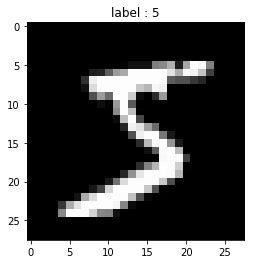

In [5]:
print ("mnist_rtain 길이 : ", len(mnist_train))
print ("minst_test 길이 : ", len(mnist_test))

# 데이터 하나 형태
image , label = mnist_train.__getitem__(0) # 0 번째 데이터
print("image data 형태 : ", image.size())
print("ㅣ뮤디 : ", label)


# 그리기
img = image.numpy() # image 타입을 numpy로 변환(1,28,28)
plt.title("label : %d"%label)
plt.imshow(img[0], cmap='gray')
plt.show()

# 3. 데이터 로드함수

In [6]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset = mnist_train, # mnist_train 을 트레인 시키자
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last = True) # batch_size만큼 나눌 때 나머지는 버려라
test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         drop_last = True) # test 에서는 shuffle 하지 않음

## 데이터 로드함수 이해하기

[0]
('\xed\x95\x9c \xeb\xb2\x88\xec\x97\x90 \xeb\xa1\x9c\xeb\x93\x9c\xeb\x90\x98\xeb\x8a\x94 \xeb\x8d\xb0\xec\x9d\xb4\xed\x84\xb0 \xed\x81\xac\xea\xb8\xb0:', 100)


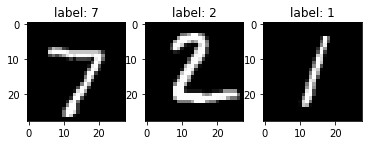

[1]
('\xed\x95\x9c \xeb\xb2\x88\xec\x97\x90 \xeb\xa1\x9c\xeb\x93\x9c\xeb\x90\x98\xeb\x8a\x94 \xeb\x8d\xb0\xec\x9d\xb4\xed\x84\xb0 \xed\x81\xac\xea\xb8\xb0:', 100)


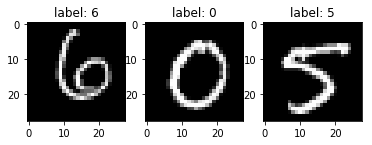

[2]
('\xed\x95\x9c \xeb\xb2\x88\xec\x97\x90 \xeb\xa1\x9c\xeb\x93\x9c\xeb\x90\x98\xeb\x8a\x94 \xeb\x8d\xb0\xec\x9d\xb4\xed\x84\xb0 \xed\x81\xac\xea\xb8\xb0:', 100)


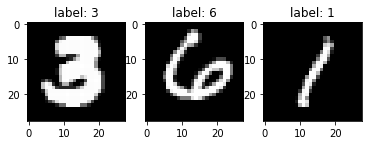

[3]
('\xed\x95\x9c \xeb\xb2\x88\xec\x97\x90 \xeb\xa1\x9c\xeb\x93\x9c\xeb\x90\x98\xeb\x8a\x94 \xeb\x8d\xb0\xec\x9d\xb4\xed\x84\xb0 \xed\x81\xac\xea\xb8\xb0:', 100)


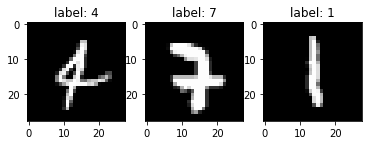

[4]
('\xed\x95\x9c \xeb\xb2\x88\xec\x97\x90 \xeb\xa1\x9c\xeb\x93\x9c\xeb\x90\x98\xeb\x8a\x94 \xeb\x8d\xb0\xec\x9d\xb4\xed\x84\xb0 \xed\x81\xac\xea\xb8\xb0:', 100)


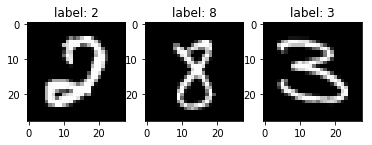

[5]
('\xed\x95\x9c \xeb\xb2\x88\xec\x97\x90 \xeb\xa1\x9c\xeb\x93\x9c\xeb\x90\x98\xeb\x8a\x94 \xeb\x8d\xb0\xec\x9d\xb4\xed\x84\xb0 \xed\x81\xac\xea\xb8\xb0:', 100)


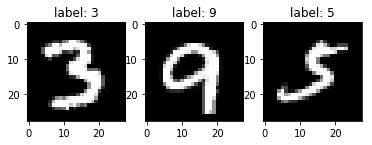

In [7]:
n = 3 #샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): #batch size만큼
    if i>5:
        break
        
    print("[%d]"%i)
    print("한 번에 로드되는 데이터 크기:", len(imgs))
    
    # 그리기
    for j in range(n):
        img = imgs[j].numpy() #image 타입을 numpy로 변환(1,28,28)
        img = img.reshape((img.shape[1], img.shape[2])) # (1,28,28) -> (28,28)
        # print img.shape
        
        plt.subplot(1, n, j+1)
        plt.imshow(img, cmap = 'gray')
        plt.title("label: %d"%labels[j])
        
    plt.show()

# 4. 모델 선언

In [8]:
# Recurrent neural network(m : 1)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # -------------------------
        # input tensor : (batch_size, seq_length, input_size)
        # x : (100,28,28)
        # print('x: ', x.shape)
        # -------------------------

        # -------------------------
        # hidden state tensor : (# of layers, batch_size, hidden_size)
        # h : (2, 100, 128)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # -------------------------
        
        # -------------------------
        # Forward propagate LSTM
        # output tensor : (barch_size, seq_length, hidden_size)
        # out : (100,28, 128)
        # print('out: ', out.shape)
        
        out, _ = self.lstm(x,(h0,c0))
        # --------------------------
        
        # ---------------------------
        # 28번째 output layer : (bs, hidden_size)
        # out[:,-1,:] : (100,128)
        # print('out[-1]:', out[:,01,:].shape)
        # ----------------------------
        
        # -----------------------------
        out = self.fc(out[:, -1,:])
        
        # y^ : (batch_size, num_classes)
        # y_pred : (100,10)
        # print('out:' , out.shape)
        
        return out
        


In [9]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [10]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [img, labels] in enumerate(dloader): # batch_size  만큼
        # x: (batch_size, 1, seq_length, input_size) -> (batch_size, seq_length, input_size)
        
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)
        
        # y : (batch_size, num_classes)
        
        label = labels.to(device) # y # Variable(labels)
        
#         label = Variable(labels).cuda()
        
        # Forward prop.
        output = imodel(img) # (batch_size, num_classes)
        _, output_index = torch.max(output, 1) # (batch_size, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
        
        return (100*correct/total).numpy() #tencor -> numpy

In [11]:
print("Accuracy of Test Data: %.2f"%ComputeAccr(test_loader, model))

Accuracy of Test Data: 11.00


# 5. Loss, optimizer

In [12]:
# Loss and optimizer

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# 6. 학습

In [17]:
# Train the model

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i , [imgs, labels] in enumerate(train_loader):
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)
        
        label = labels.to(device)
        
        outputs = model(img)
        loss = loss_func(outputs, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i +1) % 100 == 0 :
            print('Epoch [{}/{}], Step [{},{}], Loss : {:.4f}, Accr: {:.2f}').format(epoch+1, num_epochs, i+1, total_step,
                                                                                     loss.item(),ComputeAccr(test_loader, model))

Epoch [1/2], Step [100,600], Loss : 0.5664, Accr: 7.00
Epoch [1/2], Step [200,600], Loss : 0.2768, Accr: 4.00
Epoch [1/2], Step [300,600], Loss : 0.2403, Accr: 8.00
Epoch [1/2], Step [400,600], Loss : 0.0739, Accr: 8.00
Epoch [1/2], Step [500,600], Loss : 0.1993, Accr: 20.00
Epoch [1/2], Step [600,600], Loss : 0.1909, Accr: 12.00
Epoch [2/2], Step [100,600], Loss : 0.1378, Accr: 14.00
Epoch [2/2], Step [200,600], Loss : 0.0541, Accr: 9.00
Epoch [2/2], Step [300,600], Loss : 0.0528, Accr: 6.00
Epoch [2/2], Step [400,600], Loss : 0.0948, Accr: 11.00
Epoch [2/2], Step [500,600], Loss : 0.1157, Accr: 7.00
Epoch [2/2], Step [600,600], Loss : 0.0554, Accr: 14.00


# 7. 테스트

In [18]:
print("Accuracy of Test Data: %.2f"%ComputeAccr(test_loader, model))

Accuracy of Test Data: 14.00


# 8. 학습된 파라미터 저장

In [20]:
netname = './nets/rnn_weight.pkl'
torch.save(model, netname,)

/usr/local/anaconda2/lib/python2.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# 9. 학습된 파라미터 로드

In [21]:
netname = './nets/rnn_weight.pkl'
model = torch.load(netname)

In [22]:
print("Accuracy of Test Data: %.2f"%ComputeAccr(test_loader, model))

Accuracy of Test Data: 14.00
